## Detecting Diabetic Retinopathy With Deep Learning

Diabetic retinopathy is the leading cause of blindness in the working-age population of the developed world. It is estimated to affect over 93 million people.

Previous efforts have made good progress using image classification, pattern recognition, and machine learning. With photos of eyes as input, the goal of this project is to use transfer learning to create a model, that can be used to accurately detect the presence of diabetic retinopathy in eyes



In [1]:
# Importing the relevant packages  

import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# automatically reload if any changes are made to the .py file
%load_ext autoreload
%autoreload 2

In [2]:
# Import fast ai packages

from fastai.dataset import ModelData
from fastai.imports import *
from fastai.torch_imports import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from fastai.learner import Learner

/home/pranavsm24/.local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
# Import torch packages

import torch
from torchvision import transforms,models
from torch.utils.data import DataLoader,Dataset
from torch.utils.data.sampler import SubsetRandomSampler

## Exploratary Data Analysis

The distribution of classes in the dataset are as follows


                Value counts  Percentage
Normal                 25810   73.478335
Moderate NPDR           5292   15.065763
Mild NPDR               2443    6.954962
Severe NPDR              873    2.485338
Proliferate DR           708    2.015601




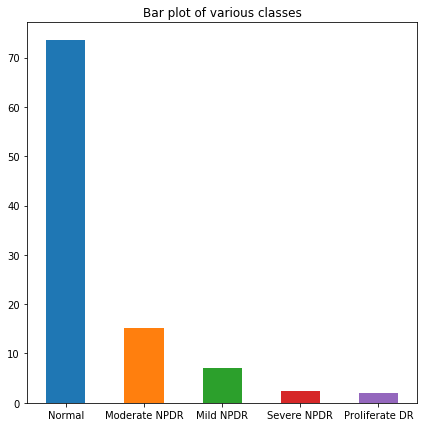

In [6]:
labels = pd.read_csv('projects/trainLabels.csv',encoding = 'UTF-8',engine='python')
labels.set_index("image", inplace=True)

print('The distribution of classes in the dataset are as follows')
print('\n')
Label_names = {0:'Normal',1:'Mild NPDR',2:'Moderate NPDR',3:'Severe NPDR',4:'Proliferate DR'}
labels['level'] = labels['level'].map(Label_names)

# percentage in each class
percentage = labels['level'].value_counts(normalize=True) * 100

# data points in each class
count_classes = labels['level'].value_counts()

print(pd.concat([count_classes, percentage], axis=1,keys=['Value counts','Percentage']))
print('\n')

percentage.plot(kind='bar',title='Bar plot of various classes',rot='horizontal',figsize=((7,7)))

It can be observed that the classes are not balanced. 

The height of the image is : 1920
The width of the image is : 2560
The image has 3 color channels


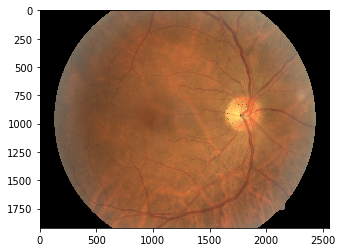

In [183]:
# Visualizing a sample image

test_image2 = mpimg.imread(r'projects/train/197_right.jpeg')
plt.imshow(test_image2)
print('The height of the image is : {}'.format(test_image2.shape[0]))
print('The width of the image is : {}'.format(test_image2.shape[1]))
print('The image has {} color channels'.format(test_image2.shape[2]))

In [7]:
def plot_images(ext,par_dir,mode):

    image_names = [par_dir+'19_right'+ext,par_dir+'214_left'+ext,
                   par_dir+'219_left'+ext,par_dir+'2275_left'+ext,
                   par_dir+'2031_right'+ext]

    plt.figure(figsize=(10,10))
    gs1 = gridspec.GridSpec(4, 4)
    gs1.update(wspace=0.025, hspace=0.05)

    for i in range(len(image_names)):
        image = mpimg.imread(image_names[i])
        plt.subplot(3,2,i+1)
        plt.axis('off')
        plt.imshow(image)
        if mode == 'before_preprocessing':
            plt.text(15,-125,'{}'.format(Label_names[i]),fontsize=15)
        elif mode == 'after_preprocessing':
            plt.text(15,-15,'{}'.format(Label_names[i]),fontsize=15)
        else:
            raise ValueError('Please enter proper mode')

## Plot images of each class before preprocessing

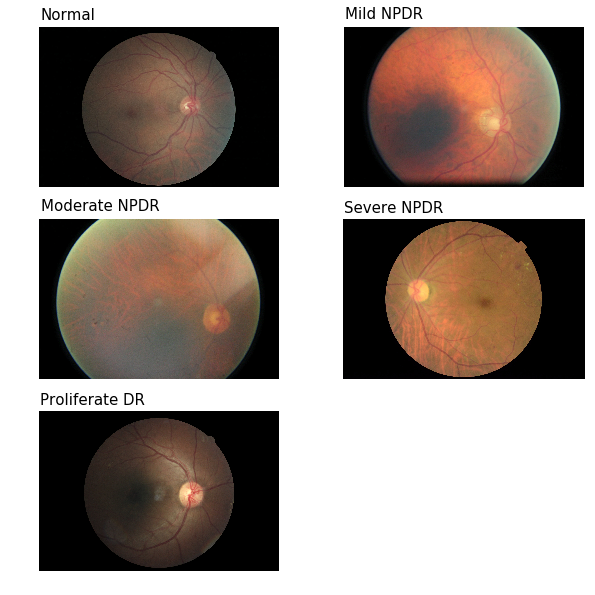

In [25]:
# Visualizing images from each class. The images were obtained after manually checking the dataset
ext = '.jpeg'
par_dir = 'projects/train/'
mode = 'before_preprocessing'

plot_images(ext,par_dir,mode)

## Preprocessing Pipeline

Nearly all the images are taken of different people, using different cameras, and of different sizes.This data is extremely noisy, and requires multiple preprocessing steps to get all images to a format appropriate for training a model.

The preprocessing pipeline consists of five steps. Please refer Preprocessing.py to view them.

(1) scaling the radius of the eye,

(2) cropping and resizing,

(3) removing high frequency noise,

(4) image blending,

(5) contrast limited adaptive histogram equalization

In [37]:
# call the module 
import Preprocessing 

In [37]:
# the entire preprocessing pipeline
Preprocessing.preprocessing_pipeline()

## Plot images after preprocessing

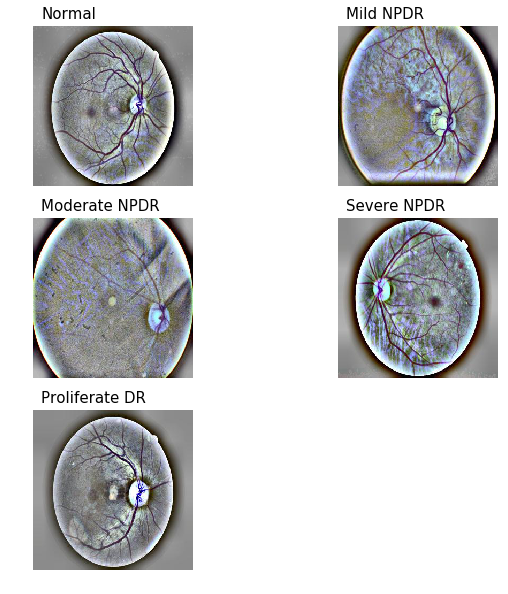

In [13]:
ext = '.jpeg'
par_dir_preprocess = 'projects/Images/Processed_images/'
mode_preprocess = 'after_preprocessing'

plot_images(ext,par_dir_preprocess,mode_preprocess)

## Preparing the data

For this particular problem I made my custom data loader. Please refer to dataloader.py file for more information

In [17]:
# Loading the DataLoader
from data_loader import DiabeticRetinopathyDataset

In [18]:
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(degrees = [0,270]),
                                      transforms.RandomVerticalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])

valid_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])
        
# Create the train and validation datasets augmentation only on train dataset

train_dataset = DiabeticRetinopathyDataset(csv_file = 'projects/trainLabels.csv',
                                              root_dir = 'projects/Images/Processed_images/',
                                              transform = train_transforms)

validation_dataset = DiabeticRetinopathyDataset(csv_file = 'projects/trainLabels.csv',
                                              root_dir = 'projects/Images/Processed_images/',
                                              transform = valid_transforms)

        
# Create the test dataset

test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])

test_dataset = DiabeticRetinopathyDataset(csv_file = 'projects/Test/retinopathy_solution.csv',
                                              root_dir = 'projects/Test/Processed_test_images',
                                              transform = test_transforms)

## Creating the train loader and validation loader

The dataset is highly imbalanced. Therefore I tried 3 methods initially:

(1) WeightedRandomsampler in pytorch

(2) Cost sensitive classification

(3) Data augmentation of minority class

The aforementioned methods weren't giving me good results so I modified an existing imbalanced dataset sampler. Please refer to Smpler.py for additional details

In [19]:
from Sampler import ImbalancedDatasetSampler

In [20]:
def Val_and_train_loader(train_set,validation_set,per_of_val=0.1,batch_train=64,batch_val=32):
    """
    Parameters:
        per_of_val : split for validation data
    
    return: 
        trainloader and validation loader
    """
   
    
    dataset_length = len(train_set)
    indices = list(range(dataset_length))
    split = int(per_of_val * dataset_length)
    
    valid_idx = np.random.choice(indices,size=split,replace=False)
    train_idx = list(set(indices) - set(valid_idx))
   
    train_dataset = torch.utils.data.dataset.Subset(train_set,train_idx)
    
    validation_sampler = SubsetRandomSampler(valid_idx)
    train_sampler = ImbalancedDatasetSampler(train_dataset)
                            
    train_loader = DataLoader(train_dataset, batch_size = batch_train,sampler = train_sampler)
    validation_loader = DataLoader(validation_set,batch_size=batch_val,sampler=validation_sampler)
    
    return train_loader,validation_loader

The below statement takes a while to run

In [21]:
# train and validation loader
train_loader,validation_loader = Val_and_train_loader(train_dataset,validation_dataset)

# test loader
test_loader = DataLoader(test_dataset,batch_size=64,shuffle=False)

In [22]:
# get the data from the fast ai dataloaders

data = ModelData.from_dls('./',train_loader,validation_loader,test_dl=test_loader)

## Defining the Model- Transfer Learning

In [25]:
num_classes = 5 # this problem has 5 classes
model = ConvnetBuilder(resnet50,is_multi=False,is_reg=False,c=num_classes)

##  Defining Loss function,optimizer and finding optimal learning rate

In [26]:
# cross entropy loss for multi class classification

criterion = nn.CrossEntropyLoss()
learn = Learner(data,model,opt_fn=torch.optim.Adam,crit=criterion)

In [27]:
learn.summary

<bound method Learner.summary of Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stri

 44%|████▍     | 217/494 [03:21<04:14,  1.09it/s, loss=3.17]

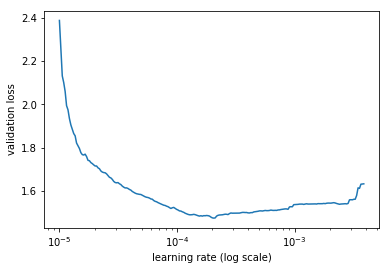

In [29]:
# freezing all layers except the fully connected layers

learn.bn_freeze(do_freeze=True)

# using the lr_finder to find plot graph and find optimal learning rate

lr_finder=learn.lr_find(wds = 1e-2, use_wd_sched=True, start_lr=1e-05, end_lr=10)
learn.sched.plot(n_skip=0,n_skip_end=2)

In [30]:
#Use this to free more GPU memory 
torch.cuda.empty_cache()

## Defining the metric and running the training procedure on the fully connected layers

In [32]:
# Please refer Kappa.py
from Kappa import cohen_kappa_score

In [33]:
# from the graph optimal learning rate is obtained
lr = 0.001
result,values = result, ep_vals = learn.fit(lrs=lr, n_cycle=1, cycle_len=8, use_clr_beta=(10,10,0.95,0.85), 
                                            wds=1e-2, use_wd_sched=True, get_ep_vals=True,metrics=[cohen_kappa_score])

epoch      trn_loss   val_loss   cohen_kappa_score           
    0      1.242133   1.237384   0.313412  
    1      1.15612    1.022681   0.430413                    
    2      1.18135    0.986394   0.453329                    
    3      1.177608   1.254774   0.266704                    
    4      1.100482   0.932126   0.49791                     
    5      1.065746   0.960093   0.479491                    
    6      1.012828   0.983314   0.470982                    
    7      0.963357   0.950678   0.502149                    


## Defining the metric and running the training procedure on all the layers

 54%|█████▍    | 267/494 [04:06<03:29,  1.09it/s, loss=1.44] 

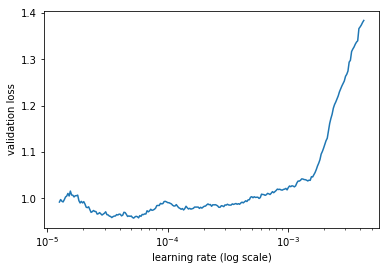

In [34]:
# unfreeze layers
learn.unfreeze()
torch.cuda.empty_cache()

lrf=learn.lr_find(wds = 1e-3, use_wd_sched=True, start_lr=1e-05, end_lr=1)
learn.sched.plot()

In [74]:
# unfreezing all the layers
learn.unfreeze()

lr1 = 0.00001
wd = 1e-2

# using discriminative fine tuning and weight decay
lrs = np.array([lr/100,lr/10,lr])
wds = np.array([wd/100,wd/10,wd])


In [68]:
learn.fit(lrs=lrs, n_cycle=2, cycle_len=1, use_clr_beta=(10, 10,0.95,0.85), 
          wds=wds,use_wd_sched=True,metrics=[cohen_kappa_score])

epoch      trn_loss   val_loss   cohen_kappa_score           
    0      0.901676   0.939089   0.514708  
    1      0.899037   0.945376   0.527888                    


[0.9453759600741445, 0.5278882284619609]

In [75]:
learn.fit(lrs=lrs,n_cycle=3,metrics = [cohen_kappa_score])

epoch      trn_loss   val_loss   cohen_kappa_score           
    0      0.864693   0.932506   0.486776  
    1      0.862586   1.008038   0.490238                    
    2      0.837682   0.915712   0.546629                    


[0.9157122176709099, 0.54662936360783]

In [67]:
# save the model in fast ai
learn.save('model2_fastai')

## Test on testing set

In [77]:
predictions = learn.predict(is_test=True)

In [78]:
values = np.exp(predictions)
final_predictions = np.argmax(values,axis=1)

## Convert to csv for submission to kaggle

In [79]:
image_names = pd.read_csv('projects/Test/retinopathy_solution.csv')
dataframe = pd.DataFrame({'image': image_names['image'], 'level': list(final_predictions)})

In [81]:
dataframe.to_csv('submi_fastai2.csv',index=False)

The above model yields a kappa value of 0.55081 which is rank 65 out of 661 competitors. Further experimentation is required to improve the model